# Bow-Tie I

In this toy model, we will show how ELK works in simple directed, sparse networks with two clusters bonded by a single node. This is an expected topology for nodes with overlapping community memberships (NOC). 

First, let's import some libraries.

In [1]:
T = True
F = False
# Python libs ----
import numpy as np
# ELK libs ----
from networks.toy import TOY
from modules.main import ELK
from modules.colregion import colregion
from plotting_jupyter.plotting_H import Plot_H
from various.network_tools import get_labels_from_Z, omega_index_format, get_best_kr_equivalence, skim_partition

The make_toys function, as its name suggests, creates the networks that we are going to use in this example. It produces 12 networks, but we will just cover four: toy_0, toy_6, toy_3, and toy_1. As it can be read in the code, the networks with several nodes have a basic layout with two main clusters with strong connections. There is also node A which can have six out of the twelve connections with two different strengths. The algorithm places the six connections in a sequence.

In [2]:
def make_toys(**kwargs):
  ww = 1
  ws = 5

  toy = np.array(
    [
      [0, -1, -1, -1, -1, -1, -1],
      [-1, 0, ws, ws, 0, 0, 0],
      [-1, 0, 0, ws, 0, 0, 0],
      [-1 ,ws ,0, 0, 0, 0 ,0],
      [-1, 0, 0, 0, 0, ws, ws],
      [-1, 0, 0, 0, ws, 0, 0],
      [-1, 0, 0, 0, ws, ws, 0]
    ]
  )

  n = (toy.shape[0] - 1) * 2
  A = np.array(
    [
      ww, ww, ww,
      ws, ws, ws,
      0, 0, 0,
      0, 0, 0
    ]
  )
  x = np.arange(n)
  NETS = []
  rows, cols = np.where(toy == -1)
  for i in [0, 6, 3, 1]:
    wheel = np.zeros(n)
    wheel[i:] = x[:(n-i)]
    wheel[:i] = x[(n-i):]
    wheel = wheel.astype(int)
    toy_copy = toy.copy()
    toy_copy[rows, cols] = A[wheel]
    NETS.append(
      TOY(toy_copy.astype(float), **kwargs)
    )
  return n, NETS

Here, we set up the code to run the link communities, compute the quality functions, and extract the node hierarchy, as usual.

In [3]:
linkage = "single"
lookup = F
cut = F
mode = "ZERO"
topology = "MIX"
index = "H2"
score = "_D"
nodes = 7

properties = {
  "lookup" : lookup,
  "cut" : cut,
  "topology" : topology,
  "index" : index
}

N, NETS = make_toys(**properties)
original_labels = np.array(["A", "B", "C", "D", "E", "F", "G"])
labels_dict = dict()
for i in np.arange(nodes):
  labels_dict[i] = original_labels[i]
toy_names = np.arange(N).astype(int).astype(str)

HS = []
for i, net in enumerate(NETS):
  print(f"\n\n\tAnalysing toy: {toy_names[i]}")
  net.set_labels(original_labels)
  h = ELK(net.A, nodes, linkage, mode, **properties)
  ## Compute features ----
  h.compute_H_features_cpp()
  ## Compute link entropy ----
  h.link_entropy_cpp("short", cut=cut)
  ## Compute lq arbre de merde ----
  h.la_abre_a_merde_cpp()
  ## Compute node entropy ----
  h.node_entropy_cpp("short", cut=cut)
  # Set labels to network ----
  L = colregion(net)
  L.get_regions()
  h.set_colregion(L)
  HS.append(h)



	Analysing toy: 0
Compute link hierarchical agglomeration ----
	> Compute features

	link entropy :  Sh : 0.2656, and Sv : 0.7344


	link entropy H: Sh : 0.2137, and Sv : 0.7863

	> Compute the node hierarchy ----
50%

	Node entropy :  Sh : 0.1006, and Sv : 0.8994


	Node entropy H: Sh : 0.0761, and Sv : 0.9239



	Analysing toy: 1
Compute link hierarchical agglomeration ----
	> Compute features

	link entropy :  Sh : 0.2656, and Sv : 0.7344


	link entropy H: Sh : 0.2137, and Sv : 0.7863

	> Compute the node hierarchy ----
50%

	Node entropy :  Sh : 0.1006, and Sv : 0.8994


	Node entropy H: Sh : 0.0761, and Sv : 0.9239



	Analysing toy: 2
Compute link hierarchical agglomeration ----
	> Compute features

	link entropy :  Sh : 0.2416, and Sv : 0.7584


	link entropy H: Sh : 0.1003, and Sv : 0.8997

	> Compute the node hierarchy ----
50%

	Node entropy :  Sh : 0.2012, and Sv : 0.7988


	Node entropy H: Sh : 0.1547, and Sv : 0.8453



	Analysing toy: 3
Compute link hierarchical agglom

In this network, node A has only out connections. The first plot shows the link communities colored in the adjacency matrix. The matrix was arranged using the node dendrogram. The second plot shows that nodes EFG are forming one cluster. Due to the topology of node D, the community BCD is not formed. Node A, which is not colored, was left behind. As it is seen in the dendrogram (third), it is clustered once the rest of the nodes form one community. However, in the fourth plot, we can see the link membership of the network's links and notice how the connections from node A belong to the two groups and what is causing node D to merge to BC is one link. The last plot shows that node A was joined to the EFG cover at the best link density partition. At the same time, nodes B, C, and D have unassigned cover membership because they are connected to the single nodes since node A, before the cover assignment, was also a single node.

{}
{0: ['B', 'C', 'D'], 1: ['A', 'E', 'F', 'G']}
	> Plot network!!!
Visualize nodal dendrogram!!!
Draw networkx link communities!!!


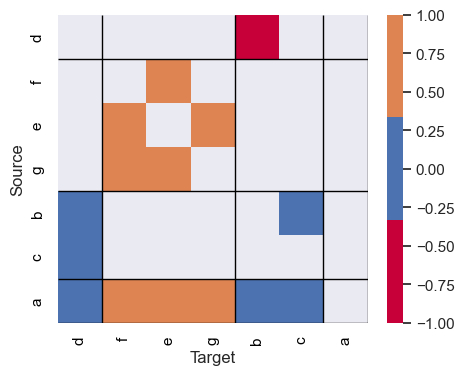

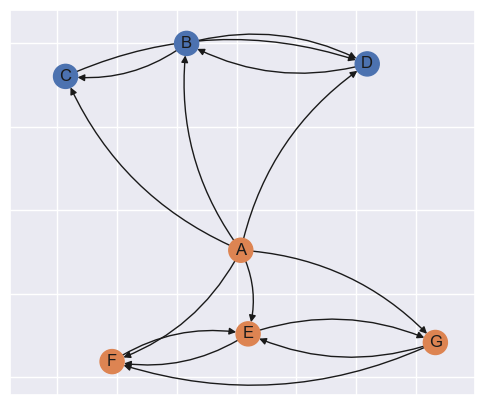

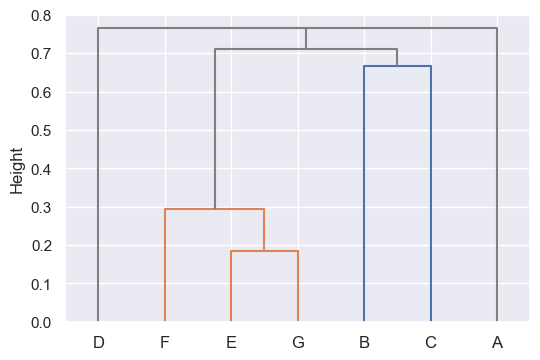

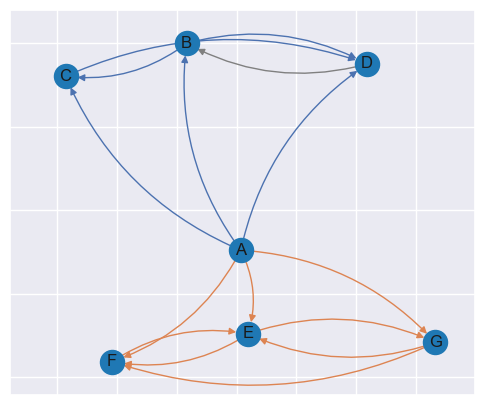

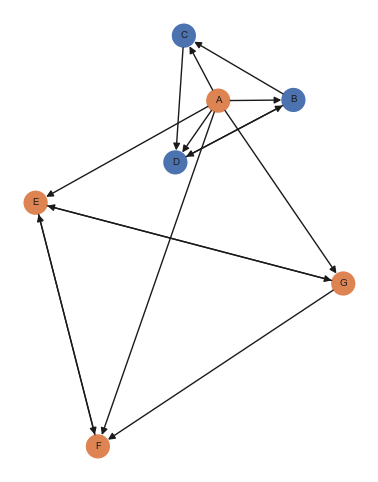

In [4]:
# Plot H ----
plot_h = Plot_H(HS[0])
# Get best k and r ----
k, r = get_best_kr_equivalence(score, HS[0])                                   # <------ Very interesting. Why?
rlabels = get_labels_from_Z(HS[0].Z, r)
rlabels = skim_partition(rlabels)
noc, subcover, sizes, rlabels2 = HS[0].discovery(rlabels, k, direction="both", index=index)
# Which are the NOCs?
print(subcover)
cover = omega_index_format(
  rlabels2, subcover, HS[0].colregion.labels[:HS[0].nodes]
)
# What is the cover?
print(cover)
# Plots
plot_h.lcmap_dendro(
  r, k, cmap_name="deep", width=5, height=4
)
plot_h.plot_network_simple(
  rlabels2, cmap_name="deep", width=6, height=5,
  labels=labels_dict
)
plot_h.nodal_dendrogram(
  r, cmap_name="deep", width=6, height=4
)
plot_h.plot_link_communities(
  k, cmap_name="deep", width=6, height=5,
  labels=labels_dict
)
plot_h.plot_network_kk(
  HS[0].A, rlabels2, subcover, sizes,
  ang=0, font_size=7, cmap_name="deep", front_edges=True
)

This example is similar to the first, but node A has only inlinks.

{}
{0: ['B', 'C', 'D'], 1: ['A', 'E', 'F', 'G']}
	> Plot network!!!
Visualize nodal dendrogram!!!
Draw networkx link communities!!!


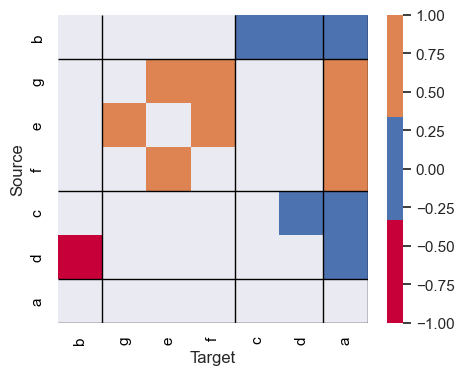

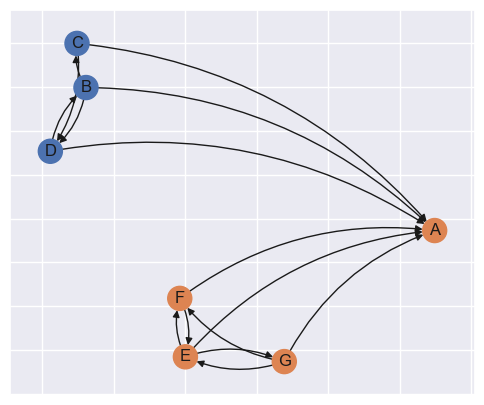

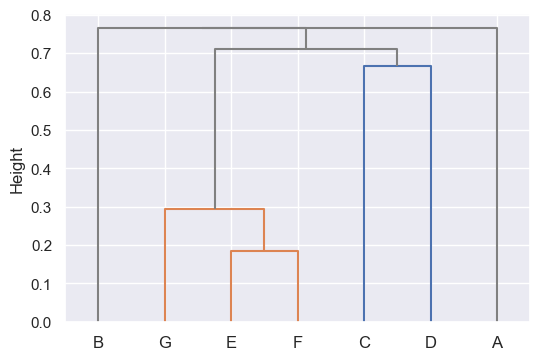

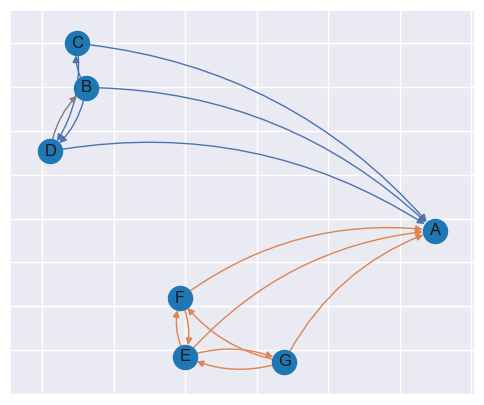

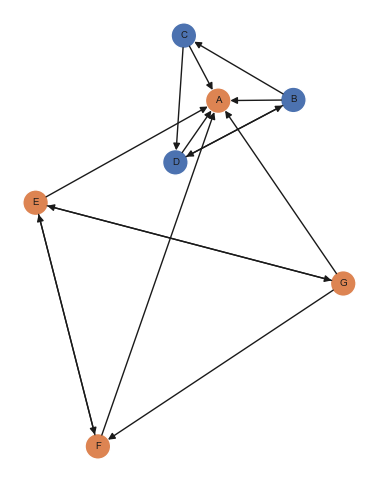

In [5]:
# Plot H ----
plot_h = Plot_H(HS[1])
# Get best k and r ----
k, r = get_best_kr_equivalence(score, HS[1])                                       # <------ Very interesting. Why?
rlabels = get_labels_from_Z(HS[1].Z, r)
rlabels = skim_partition(rlabels)
noc, subcover, sizes, rlabels2 = HS[1].discovery(rlabels, k, direction="both", index=index)
# Which are the NOCs?
print(subcover)
cover = omega_index_format(
  rlabels2, subcover, HS[1].colregion.labels[:HS[1].nodes]
)
# What is the cover?
print(cover)
# Plots
plot_h.lcmap_dendro(
  r, k, cmap_name="deep", width=5, height=4
)
plot_h.plot_network_simple(
  rlabels2, cmap_name="deep", width=6, height=5,
  labels=labels_dict
)
plot_h.nodal_dendrogram(
  r, cmap_name="deep", width=6, height=4
)
plot_h.plot_link_communities(
  k, cmap_name="deep", width=6, height=5,
  labels=labels_dict
)
plot_h.plot_network_kk(
  HS[1].A, rlabels2, subcover, sizes,
  ang=0, font_size=7, cmap_name="deep", front_edges=True
)

In this example, node A's links create a flow that has the topological role of connecting the two categories in only one direction. Notice that this topology favours the identification of the two clusters after single node cover assingment.

{'A': [0, 1]}
{0: ['B', 'C', 'D', 'A'], 1: ['E', 'F', 'G', 'A']}
	> Plot network!!!


/usr/local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1096: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


Visualize nodal dendrogram!!!
Draw networkx link communities!!!


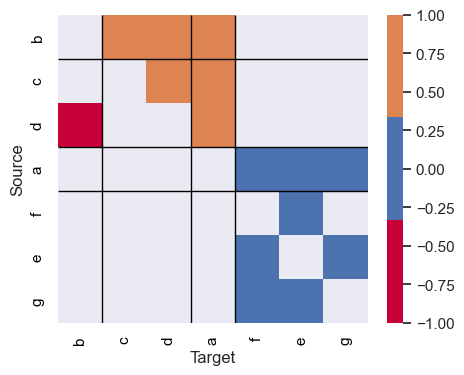

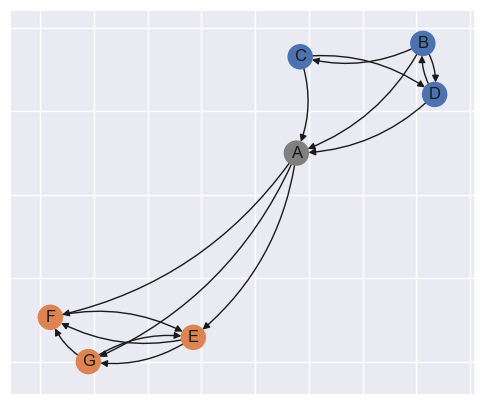

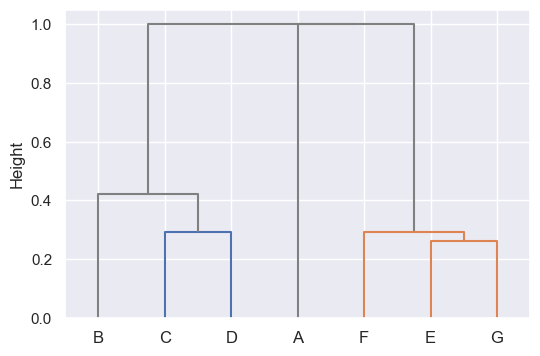

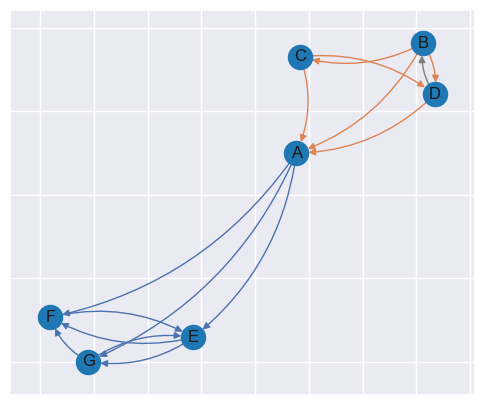

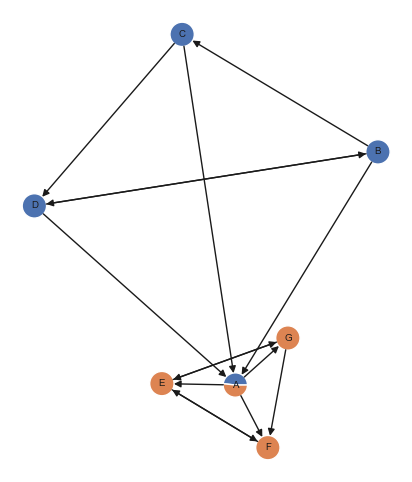

In [6]:
# Plot H ----
plot_h = Plot_H(HS[2])
# Get best k and r ----
k, r = get_best_kr_equivalence(score, HS[i])                                        # <------ Very interesting. Why?
rlabels = get_labels_from_Z(HS[2].Z, r)
rlabels = skim_partition(rlabels)
noc, subcover, sizes, rlabels2 = HS[2].discovery(rlabels, k, direction="both", index=index)
# Which are the NOCs?
print(subcover)
cover = omega_index_format(
  rlabels2, subcover, HS[2].colregion.labels[:HS[2].nodes]
)
# What is the cover?
print(cover)
# Plots
plot_h.lcmap_dendro(
  r, k, cmap_name="deep", width=5, height=4
)
plot_h.plot_network_simple(
  rlabels2, cmap_name="deep", width=6, height=5,
  labels=labels_dict
)
plot_h.nodal_dendrogram(
  r, cmap_name="deep", width=6, height=4
)
plot_h.plot_link_communities(
  k, cmap_name="deep", width=6, height=5,
  labels=labels_dict
)
plot_h.plot_network_kk(
  HS[2].A, rlabels2, subcover, sizes,
  ang=0, font_size=7, cmap_name="deep", front_edges=True
)

Lastly, the network has some in- and outlinks. We can see a fascinating phenomenon regarding link communities in sparse directed networks. We can see that in the best partition, only one group appears (second plot). In the last plot, we can see that most of the links but one are colored in the best partition. The connection from D to B remains unclustered because it needs neighbor links! The link neighborhood is empty because D has no other outlink and B no inlink. Since it cannot be compared, it remains isolated until the similarity threshold in the hierarchical agglomeration process clusters it to another link community, but this happens at the end.

Even though the blue link community picture shows that nodes A & C form a community because they have in- and outlinks, they are not classified into a cluster, as also seen in the node dendrogram (third). This is an example that finding the right node community from the link community partition still needs exploration.

{}
{0: ['A', 'B', 'C', 'D'], 1: ['E', 'F', 'G']}
	> Plot network!!!
Visualize nodal dendrogram!!!
Draw networkx link communities!!!


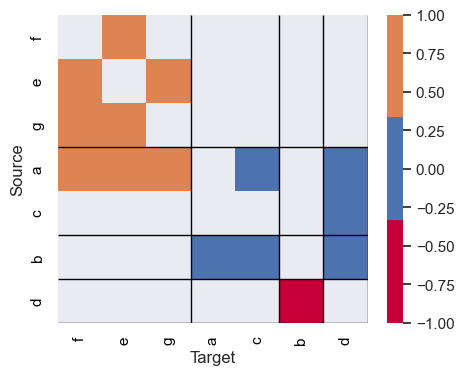

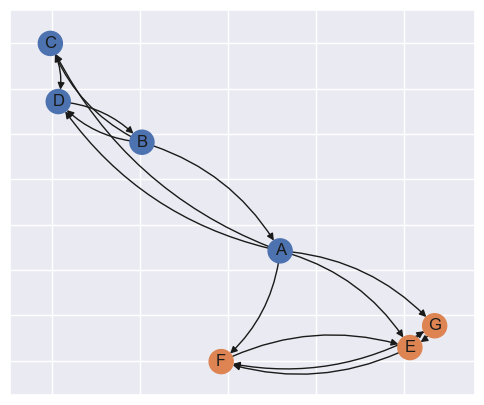

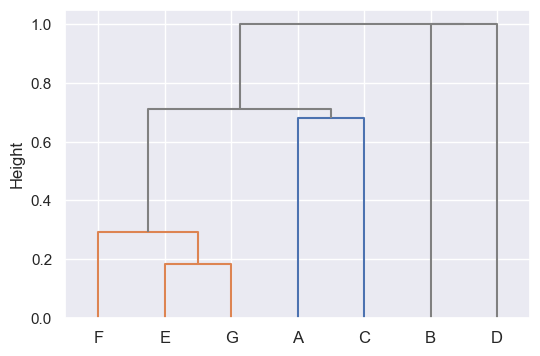

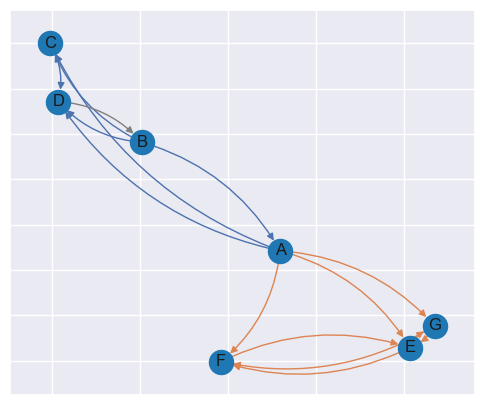

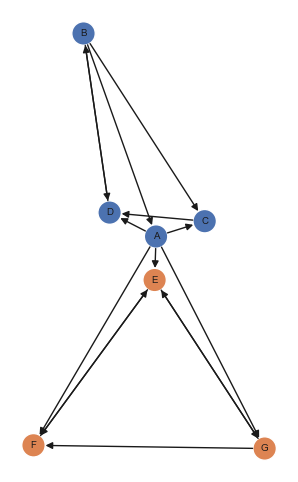

In [7]:
# Plot H ----
plot_h = Plot_H(HS[3])
# Get best k and r ----
k, r = get_best_kr_equivalence(score, HS[3])                                      # <------ Very interesting. Why?
rlabels = get_labels_from_Z(HS[3].Z, r)
rlabels = skim_partition(rlabels)
noc, subcover, sizes, rlabels2 = HS[3].discovery(rlabels, k, direction="both", index=index)
# Which are the NOCs?
print(subcover)
cover = omega_index_format(
  rlabels2, subcover, HS[3].colregion.labels[:HS[3].nodes]
)
# What is the cover?
print(cover)
# Plots
plot_h.lcmap_dendro(
  r, k, cmap_name="deep", width=5, height=4
)
plot_h.plot_network_simple(
  rlabels2, cmap_name="deep", width=6, height=5,
  labels=labels_dict
)
plot_h.nodal_dendrogram(
  r, cmap_name="deep", width=6, height=4
)
plot_h.plot_link_communities(
  k, cmap_name="deep", width=6, height=5,
  labels=labels_dict
)
plot_h.plot_network_kk(
  HS[3].A, rlabels2, subcover, sizes,
  ang=0, font_size=7, cmap_name="deep", front_edges=True
)